In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/dataset/dermoscopy'

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(-40, 40)),
        transforms.RandomResizedCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [5]:
import os
from torchvision.datasets import ImageFolder
normal_folder = os.path.join(dataset_path, 'HAM10000_images_part_1')
pneumonia_folder = os.path.join(dataset_path, 'HAM10000_images_part_2')
combined_dataset = ImageFolder(root=dataset_path, transform=data_transforms['train'])
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size])
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


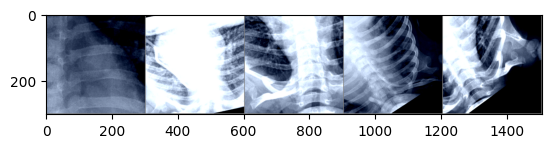

Labels: tensor([1, 1, 0, 1, 2])


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms, utils
inputs, labels = next(iter(train_loader))
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(utils.make_grid(inputs))
print('Labels:', labels)

In [7]:
for images, labels in train_loader:
    print(images.size())
    break

torch.Size([5, 3, 299, 299])


In [8]:
import os
normal_folder = os.path.join(dataset_path, 'normal')
pneumonia_folder = os.path.join(dataset_path, 'pneumonia')
print("normal Samples:", len(os.listdir(normal_folder)))
print("pneumonia Samples:", len(os.listdir(pneumonia_folder)))

normal Samples: 5
pneumonia Samples: 5


In [9]:
for batch, labels in train_loader:
    print("Batch Shape:", batch.shape)
    print("Labels:", labels)
    break

Batch Shape: torch.Size([5, 3, 299, 299])
Labels: tensor([1, 0, 1, 0, 0])


In [10]:
import torch.nn as nn
class DermoscopyEncoder(nn.Module):
    def __init__(self):
        super(DermoscopyEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, weight, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

encoder = DermoscopyEncoder()
weight = torch.randn(256)
for batch, labels in train_loader:
    features = encoder(weight, batch)
    print("Encoded Features Shape:", features.shape)
    break

Encoded Features Shape: torch.Size([5, 256])


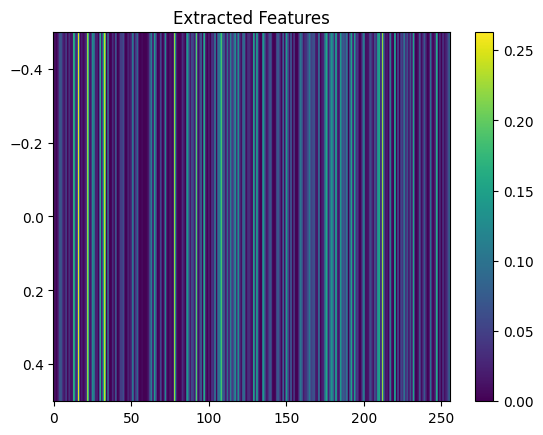

In [11]:
import matplotlib.pyplot as plt
import numpy as np
features_np = features.detach().cpu().numpy() 
feature_image = features_np[0]
# Display the feature heatmap
plt.imshow(feature_image.reshape(1, -1), cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Extracted Features')
plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AACoder(nn.Module):
    def __init__(self, input_size, noise_size, output_size):
        super(AACoder, self).__init__()
        self.fc1 = nn.Linear(input_size + noise_size, output_size)
        self.fc2 = nn.Linear(output_size, input_size)

    def forward(self, original_features, gaussian_noise, weight):
        combined_features = torch.cat((original_features, gaussian_noise), dim=1)
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)
        return x
input_size = features.size(1)  
noise_size = 100  
output_size = 256  
aacoder = AACoder(input_size, noise_size, output_size)
gaussian_noise = torch.randn(features.size(0), noise_size)
aacoder_weight = torch.randn(output_size)
attack_features = aacoder(features, gaussian_noise, aacoder_weight)

In [13]:
import torch
import torch.nn as nn
class ReconstructionBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(ReconstructionBlock, self).__init__()
        self.fc = nn.Linear(input_size, output_size) 

    def forward(self, input_features):
        return self.fc(input_features)

class AttentionBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(AttentionBlock, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, classification_features):
        attention_features = self.sigmoid(self.fc(classification_features))
        return attention_features

class CombineBlock(nn.Module):
    def __init__(self):
        super(CombineBlock, self).__init__()

    def forward(self, perturbation_restoration, attention_features):
        final_perturbation = perturbation_restoration * attention_features
        return final_perturbation

class Decoder(nn.Module):
    def __init__(self, reconstruction_input_size, attention_input_size, perturbation_restoration_output_size):
        super(Decoder, self).__init__()
        self.reconstruction_block = ReconstructionBlock(reconstruction_input_size, perturbation_restoration_output_size)
        self.attention_block = AttentionBlock(attention_input_size, perturbation_restoration_output_size)
        self.combine_block = CombineBlock()

    def forward(self, classification_features, attack_features):
        attention_features = self.attention_block(classification_features)
        perturbation_restoration = self.reconstruction_block(attack_features)
        final_perturbation = self.combine_block(perturbation_restoration, attention_features)
        return final_perturbation


dermoscopy_encoder_output_size = 256
aacoder_output_size = 256
decoder_output_size = 1280
reconstruction_input_size = aacoder_output_size  
attention_input_size = dermoscopy_encoder_output_size  
perturbation_restoration_output_size = decoder_output_size  
decoder = Decoder(reconstruction_input_size, attention_input_size, perturbation_restoration_output_size)


classification_features = torch.randn(5, attention_input_size)  
attack_features = torch.randn(5, reconstruction_input_size)     
final_perturbation = decoder(classification_features, attack_features)
print("Final Perturbation Shape:", final_perturbation.shape)


Final Perturbation Shape: torch.Size([5, 1280])


In [14]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Normalize input data
        x = x / torch.max(torch.abs(x)) 

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def wasserstein_distance(features1, features2):
    w_distance = torch.mean(features1 - features2)
    return w_distance


SCE

In [17]:
import torch
import torch.nn.functional as F

# Define the SCE defense function
def stochastic_collapsed_ensemble(model, images, epsilon, alpha, num_iter, num_samples):
    images = images.clone().detach().requires_grad_(True)
    perturbations = torch.zeros_like(images)  # Initialize perturbations
    for _ in range(num_samples):
        images_copy = images.clone().detach().requires_grad_(True)
        for _ in range(num_iter):
            outputs = model(images_copy)
            loss = F.binary_cross_entropy_with_logits(outputs, torch.ones_like(outputs))  # Binary cross-entropy loss
            loss.backward()

            # PGD step
            with torch.no_grad():
                images_grad = images_copy.grad.sign()
                images_copy = images_copy + alpha * images_grad
                images_copy = torch.max(torch.min(images_copy, images_copy + epsilon), images_copy - epsilon)
                images_copy = torch.clamp(images_copy, 0, 1)
                images_copy = images_copy.detach().requires_grad_(True)

        # Accumulate perturbations
        perturbations += images_copy - images

    # Average perturbations over ensemble
    perturbations /= num_samples

    # Apply perturbations to original images
    defended_images = images + perturbations

    return defended_images


hidden_size = 128
output_size = 1  

discriminator = Discriminator(input_size, hidden_size, output_size)

# Define SCE defense parameters
epsilon = 0.03  
alpha = 0.01    
num_iter = 10  
num_samples = 5  
# Iterate through the dataset
for i, (batch, labels) in enumerate(train_loader):
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_samples = batch + restored_perturbations_reshaped
    # Apply SCE defense to adversarial samples
    defended_samples = stochastic_collapsed_ensemble(discriminator, adversarial_samples, epsilon, alpha, num_iter, num_samples)
    flattened_defended_samples = defended_samples.view(defended_samples.size(0), -1)
    discriminator_output = discriminator(flattened_defended_samples)
    w_distance = wasserstein_distance(original_features, discriminator_output)
    classified_sample = "real" if w_distance >= threshold else "fake"

    # Print the classification result for each adversarial sample
    for j in range(len(batch)):
        print(f"Sample {i+1}, Adversarial Sample {j+1}: {classified_sample}")
    break


Sample 1, Adversarial Sample 1: real
Sample 1, Adversarial Sample 2: real
Sample 1, Adversarial Sample 3: real
Sample 1, Adversarial Sample 4: real
Sample 1, Adversarial Sample 5: real


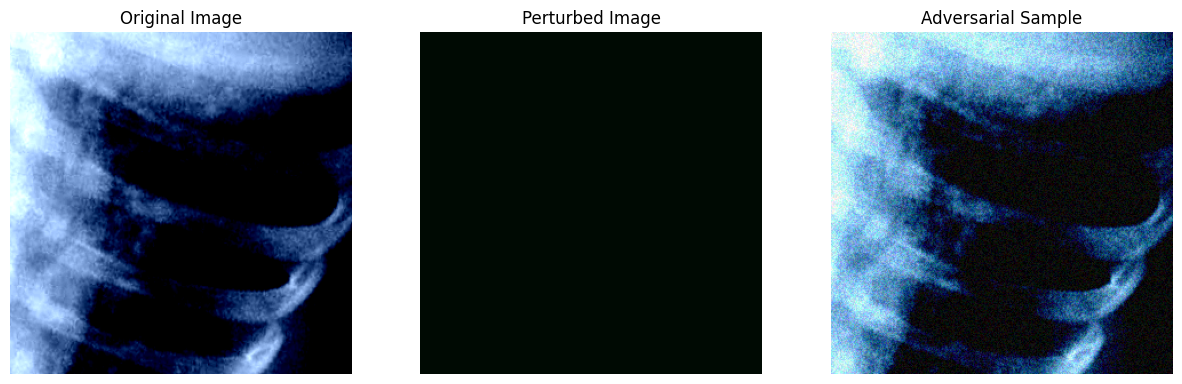

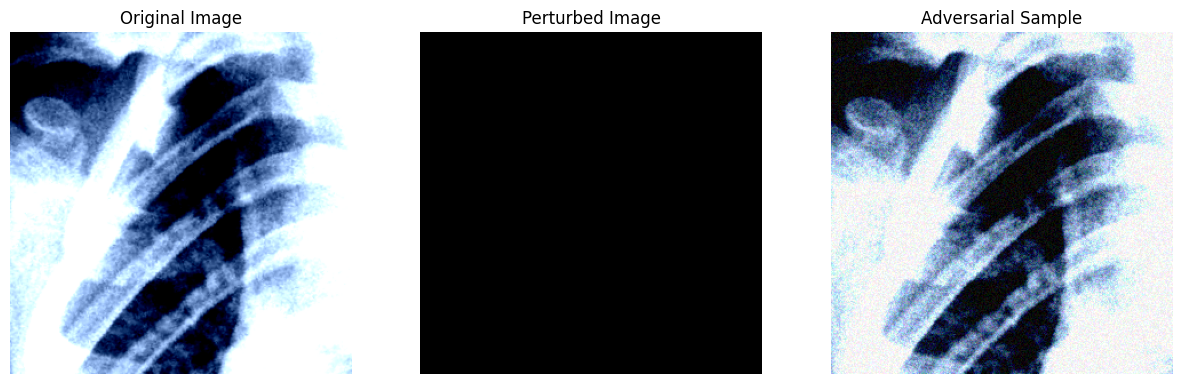

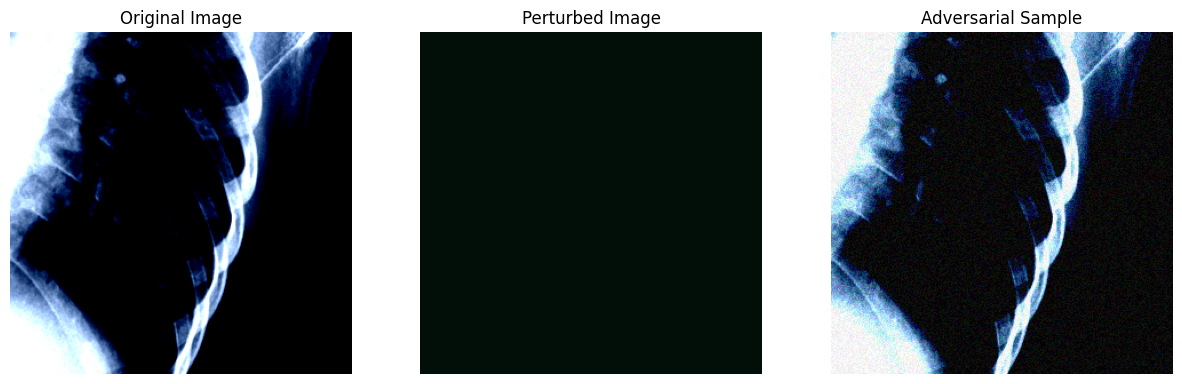

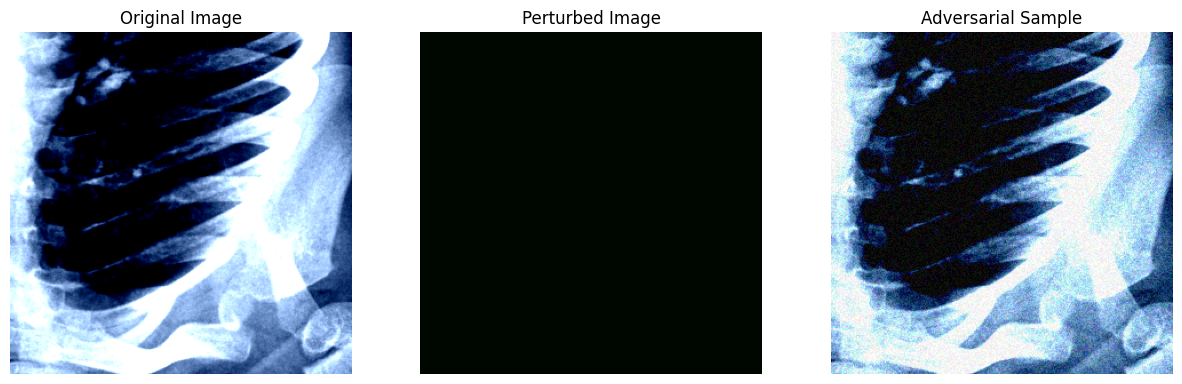

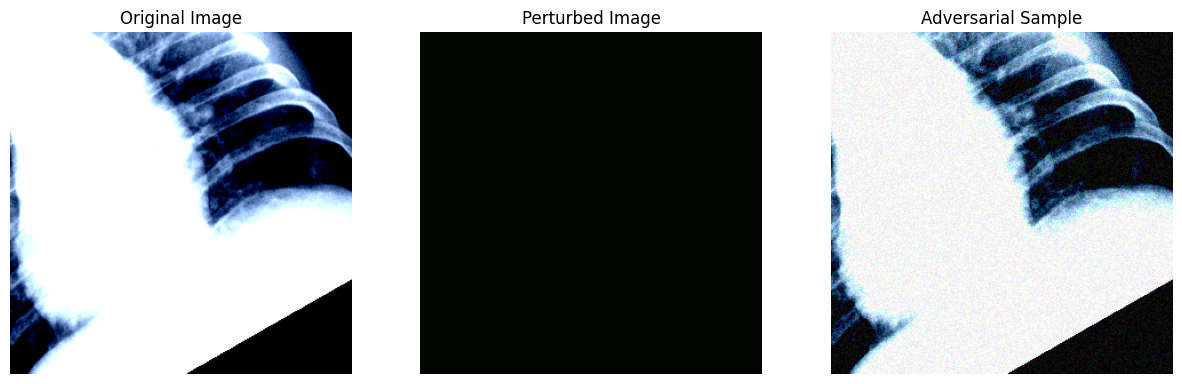

In [20]:
# Define a function to visualize images
def visualize_samples(original, perturbed, adversarial):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['Original Image', 'Perturbed Image', 'Adversarial Sample']
    samples = [original, perturbed, adversarial]
    for ax, title, sample in zip(axes, titles, samples):
        ax.imshow(np.transpose(sample.detach().numpy(), (1, 2, 0)))
        ax.set_title(title)
        ax.axis('off')
    plt.show()

# Iterate through the dataset
for batch, labels in train_loader:
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_samples = batch + restored_perturbations_reshaped

    # Apply APGD defense to adversarial samples
    defended_samples = stochastic_collapsed_ensemble(discriminator, adversarial_samples, epsilon, alpha, num_iter, epsilon_rand)
    # Visualize original image, perturbed image, and adversarial sample
    for i in range(len(batch)):
        visualize_samples(batch[i], restored_perturbations_reshaped[i], defended_samples[i])
    break


In [21]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

# Load pre-trained ResNet-50, DenseNet-121, and VGG-16 models
resnet50 = models.resnet50(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
num_classes = 2  

resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)
densenet121.classifier = torch.nn.Linear(densenet121.classifier.in_features, num_classes)
vgg16.classifier[6] = torch.nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Set models to evaluation mode
resnet50.eval()
densenet121.eval()
vgg16.eval()

# Define transformations for input images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to classify an image using a model
def classify_image(image, model):
    image = Variable(image.unsqueeze(0))
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    return predicted.item()

# Iterate through the dataset
for batch, labels in train_loader:
    # Pass adversarial samples through ResNet-50
    resnet_predictions = []
    for sample in adversarial_samples:
        resnet_pred = classify_image(sample, resnet50)
        resnet_predictions.append(resnet_pred)

    # Pass adversarial samples through DenseNet-121
    densenet_predictions = []
    for sample in adversarial_samples:
        densenet_pred = classify_image(sample, densenet121)
        densenet_predictions.append(densenet_pred)

    # Pass adversarial samples through VGG-16
    vgg16_predictions = []
    for sample in adversarial_samples:
        vgg16_pred = classify_image(sample, vgg16)
        vgg16_predictions.append(vgg16_pred)

    # Convert predicted label indices to class labels
    class_labels = {0: 'normal', 1: 'pneumonia'}

    # Print the predicted class labels for each adversarial sample
    for i, (resnet_pred, densenet_pred, vgg16_pred) in enumerate(zip(resnet_predictions, densenet_predictions, vgg16_predictions)):
        resnet_class = class_labels[resnet_pred]
        densenet_class = class_labels[densenet_pred]
        vgg16_class = class_labels[vgg16_pred]
        print(f"Adversarial Sample {i+1}: ResNet-50 predicted label: {resnet_class}, DenseNet-121 predicted label: {densenet_class}, VGG-16 predicted label: {vgg16_class}")
    break



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Adversarial Sample 1: ResNet-50 predicted label: pneumonia, DenseNet-121 predicted label: normal, VGG-16 predicted label: pneumonia
Adversarial Sample 2: ResNet-50 predicted label: normal, DenseNet-121 predicted label: normal, VGG-16 predicted label: pneumonia
Adversarial Sample 3: ResNet-50 predicted label: pneumonia, DenseNet-121 predicted label: normal, VGG-16 predicted label: pneumonia
Adversarial Sample 4: ResNet-50 predicted label: normal, DenseNet-121 predicted label: normal, VGG-16 predicted label: pneumonia
Adversarial Sample 5: ResNet-50 predicted label: pneumonia, DenseNet-121 predicted label: normal, VGG-16 predicted label: pneumonia


In [22]:
import torch
import torch.nn.functional as F


alpha = 1.0
beta = 1.0
gamma = 1.0
c = 0.1  


def calculate_adversarial_classification_loss(outputs, labels):
    return F.cross_entropy(outputs, labels)

def calculate_adversarial_generation_loss(discriminator_outputs):
    return torch.mean(1 - discriminator_outputs)

def calculate_perturbation_magnitude_loss(perturbation):
    return torch.mean(torch.max(torch.tensor(0.0), torch.norm(perturbation, p=2) - c))

def calculate_feature_consistency_loss(features_original, features_perturbed):
    return F.mse_loss(features_original, features_perturbed)

# Iterate through the dataset
for batch, labels in train_loader:
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_samples = batch + restored_perturbations_reshaped
# Apply APGD defense to adversarial samples
    defended_samples = stochastic_collapsed_ensemble(discriminator, adversarial_samples, epsilon, alpha, num_iter, epsilon_rand)

    # Classify the adversarial samples using ResNet-50
    resnet_outputs = resnet50(defended_samples)

    # Classify the adversarial samples using DenseNet-121
    densenet_outputs = densenet121(defended_samples)

    # Classify the adversarial samples using VGG-16
    vgg16_outputs = vgg16(defended_samples)

    loss_resnet = calculate_adversarial_classification_loss(resnet_outputs, labels)
    loss_densenet = calculate_adversarial_classification_loss(densenet_outputs, labels)
    loss_vgg16 = calculate_adversarial_classification_loss(vgg16_outputs, labels)

    # Print the losses for ResNet-50, DenseNet-121, and VGG-16
    print("Adversarial Classification Loss (ResNet-50):", loss_resnet.item())
    print("Adversarial Classification Loss (DenseNet-121):", loss_densenet.item())
    print("Adversarial Classification Loss (VGG-16):", loss_vgg16.item())
    break


Adversarial Classification Loss (ResNet-50): 0.6459625959396362
Adversarial Classification Loss (DenseNet-121): 0.9096835851669312
Adversarial Classification Loss (VGG-16): 0.583746075630188


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


In [24]:
def calculate_l2_norm(original_images, adversarial_samples):
    l2_norms = []
    for original_image, adversarial_sample in zip(original_images, adversarial_samples):
        perturbation = adversarial_sample - original_image
        l2_norm = np.linalg.norm(perturbation)
        l2_norms.append(l2_norm)
    return l2_norms

# Iterate through the dataset
for batch, labels in train_loader:
    resnet_outputs = resnet50(batch)
    densenet_outputs = densenet121(batch)
    vgg16_outputs = vgg16(batch)

    resnet_preds = torch.argmax(resnet_outputs, dim=1).cpu().numpy()
    densenet_preds = torch.argmax(densenet_outputs, dim=1).cpu().numpy()
    vgg16_preds = torch.argmax(vgg16_outputs, dim=1).cpu().numpy()

   # Compute accuracy
    accuracy_resnet = accuracy_score(labels.cpu().numpy(), resnet_preds)
    accuracy_densenet = accuracy_score(labels.cpu().numpy(), densenet_preds)
    accuracy_vgg16 = accuracy_score(labels.cpu().numpy(), vgg16_preds)

# Compute AUC
    auc_resnet = roc_auc_score(labels.cpu().numpy(), resnet_outputs[:, 1].detach().cpu().numpy())
    auc_densenet = roc_auc_score(labels.cpu().numpy(), densenet_outputs[:, 1].detach().cpu().numpy())
    auc_vgg16 = roc_auc_score(labels.cpu().numpy(), vgg16_outputs[:, 1].detach().cpu().numpy())

# Compute L2 norm
    l2_norm_resnet = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_samples.detach().cpu().numpy())
    l2_norm_densenet = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_samples.detach().cpu().numpy())
    l2_norm_vgg16 = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_samples.detach().cpu().numpy())


    # Print the metrics for each batch
    print("Accuracy (ResNet-50, DenseNet-121, VGG-16):", accuracy_resnet, accuracy_densenet, accuracy_vgg16)
    print("AUC (ResNet-50, DenseNet-121, VGG-16):", auc_resnet, auc_densenet, auc_vgg16)
    print("L2 Norm (ResNet-50):", l2_norm_resnet)
    print("L2 Norm (DenseNet-121):", l2_norm_densenet)
    print("L2 Norm (VGG-16):", l2_norm_vgg16)
    break


Accuracy (ResNet-50, DenseNet-121, VGG-16): 0.4 0.4 0.6
AUC (ResNet-50, DenseNet-121, VGG-16): 0.16666666666666666 0.6666666666666666 0.8333333333333333
L2 Norm (ResNet-50): [554.3521, 656.0246, 538.7284, 657.578, 727.5359]
L2 Norm (DenseNet-121): [554.3521, 656.0246, 538.7284, 657.578, 727.5359]
L2 Norm (VGG-16): [554.3521, 656.0246, 538.7284, 657.578, 727.5359]


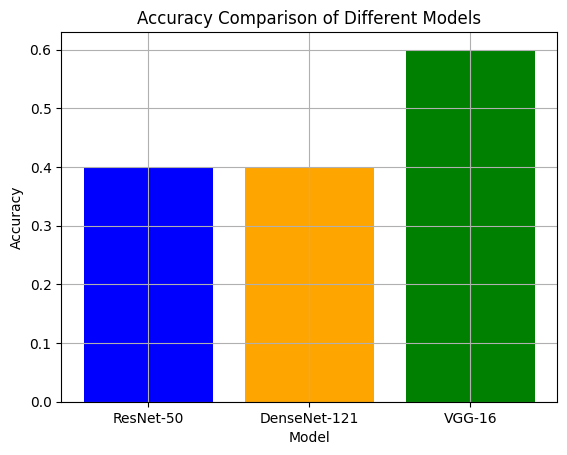

In [25]:
import matplotlib.pyplot as plt

# Define models and accuracies
models = ['ResNet-50', 'DenseNet-121', 'VGG-16']
accuracies = [accuracy_resnet, accuracy_densenet, accuracy_vgg16]  # Assuming these are single accuracy values

# Plot accuracies for each model
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')

# Show plot
plt.grid(True)
plt.show()
